In [1]:
from typing import Dict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import FashionMNIST 
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader

import brevitas.nn as qnn

## Paths and some params

In [2]:
project_path = Path.cwd().parents[1]
mnist_path = project_path/'data/fmnist'
weight_dir = project_path/'quant_he_code/weights/'

input_bit_width = 2
weight_bit_width = 2
weight_file = f"quant_fc_{input_bit_width}bits_fmnist_plain_{weight_bit_width}bits_weights.pth"

weight_file_path = weight_dir / weight_file
assert weight_file_path.exists()
weight_file_path

PosixPath('/home/dk/Desktop/projects/PocketHHE/quant_he_code/weights/quant_fc_2bits_fmnist_plain_2bits_weights.pth')

## Load the test dataset

In [3]:
def mnist_processing(option: int):
    if option == 0:
        # transform into [0.0, 0.25, 0.5, 0.75, 1.0]
        transform = transforms.Compose([
            ToTensor(),
            Lambda(torch.flatten),
            lambda x: (x*4).int(),
            lambda x: x.float()/4,
        ])
    elif option == 2:
        # transform into [0, 1, 2, 3]
        transform = transforms.Compose([
            ToTensor(),
            Lambda(torch.flatten),
            lambda x: (x * 3).int().float(),
        ])
    else:
        raise NotImplementedError
    
    test_dataset = FashionMNIST(root=mnist_path, train=False, transform=transform)
    
    return test_dataset

test_dataset = mnist_processing(option=input_bit_width)

im.shape = torch.Size([784])
Processed FashionMNIST data unique values = tensor([0., 1., 2., 3.])


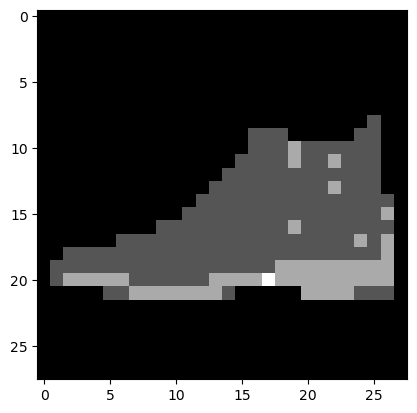

In [4]:
im = test_dataset[0][0]
print(f"{im.shape = }")
print(f"Processed FashionMNIST data unique values = {im.unique()}")
plt.imshow(im.reshape(28,28), cmap='gray')

## Define and load the network

In [5]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)  # outputs has dim [batch_size, 10]
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    """
    PytorchLightining style
    """
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch) -> Dict:
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs) -> Dict:
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result) -> None:
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch + 1, result['val_loss'], result['val_acc']))

In [6]:
class FMNISTLinearQuantModel(ImageClassificationBase):
    """
    2 linear layers + 2 square activations
    """
    def __init__(self):
        super().__init__()
        self.fc1 = qnn.QuantLinear(in_features=28*28, out_features=128, bias=False, 
                                   weight_bit_width=weight_bit_width,
                                   return_quant_tensor=True)
        
        self.fc2 = qnn.QuantLinear(in_features=128, out_features=10, bias=False, 
                                   weight_bit_width=weight_bit_width, 
                                   return_quant_tensor=True)

    def forward(self, xb):      
        out = self.fc1(xb)
        out = out * out  # first square
        out = self.fc2(out)

        return out

model = FMNISTLinearQuantModel()
model

FMNISTLinearQuantModel(
  (fc1): QuantLinear(
    in_features=784, out_features=128, bias=False
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (output_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (weight_quant): WeightQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (tensor_quant): RescalingIntQuant(
        (int_quant): IntQuant(
          (float_to_int_impl): RoundSte()
          (tensor_clamp_impl): TensorClampSte()
          (delay_wrapper): DelayWrapper(
            (delay_impl): _NoDelay()
          )
        )
        (scaling_impl): StatsFromParameterScaling(
          (parameter_list_stats): _ParameterListStats(
            (first_tracked_param): _ViewParameterWrapper(
              (view_shape_impl): OverTensorView()
            )
            (stats): _Stats(
              (stats_impl): AbsMax()
            )
          )
          (stats_scaling_impl): 

In [7]:
model.load_state_dict(
    torch.load(weight_file_path, 
    map_location=torch.device('cpu'))
)

<All keys matched successfully>

## Do inference on test dataset

In [12]:
nb_tests = 10000
test_loader = DataLoader(test_dataset, nb_tests, pin_memory=True)
for x, y in test_loader:
    print(f"unique input values = {x.unique()}")
    print(f"unique labels values = {y.unique()}")
    break

unique input values = tensor([0., 1., 2., 3.])
unique labels values = tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [13]:
def evaluate(model, val_loader) -> Dict:
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

acc = evaluate(model, test_loader)['val_acc']
print(f"test accuracy with trained {weight_bit_width}-bit weights = {acc}")

test accuracy with trained 2-bit weights = 0.8108999729156494


/tmp/ipykernel_80348/2498532057.py:2: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:363.)
  _, preds = torch.max(outputs, dim=1)  # outputs has dim [batch_size, 10]


## Manual Inference on integer data and Breavitas's integer weights

### Inspecting the Integer Model Weights

In [8]:
fc1 = model.fc1.int_weight()
fc2 = model.fc2.int_weight()
print(f"{fc1.unique() = }")
print(f"{fc2.unique() = }")
fc1 = torch.transpose(fc1, 0, 1)
fc2 = torch.transpose(fc2, 0, 1)

fc1.unique() = tensor([-1,  0,  1], dtype=torch.int8)
fc2.unique() = tensor([-1,  0,  1], dtype=torch.int8)


### Integer Data

In [9]:
test_batch_size = 10000
test_loader = DataLoader(test_dataset, test_batch_size, pin_memory=True)
x, y = next(iter(test_loader))
print(f"input: \n--{x.dtype = }, \n--{x.shape = }, \n--{x.unique() = }")
print(f"labels: \n--{y.dtype = }, \n--{y.shape = }, \n--{y.unique() = }")

input: 
--x.dtype = torch.float32, 
--x.shape = torch.Size([10000, 784]), 
--x.unique() = tensor([0., 1., 2., 3.])
labels: 
--y.dtype = torch.int64, 
--y.shape = torch.Size([10000]), 
--y.unique() = tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


class = 9


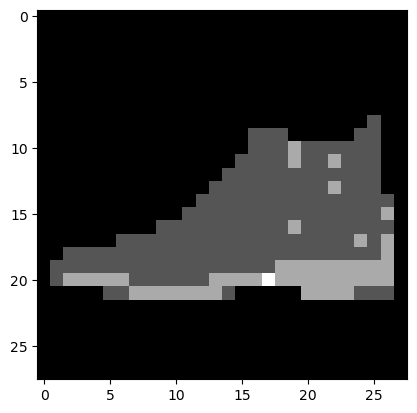

In [10]:
plt.imshow(x[0].reshape(28,28), cmap='gray')
print(f"class = {y[0]}")

### Manual Inference

In [11]:
total_acc = 0
max_value = -99999
min_value = 99999
 
torch_dtype = torch.int16
fc1 = fc1.to(dtype=torch_dtype)
fc2 = fc2.to(dtype=torch_dtype)

for im, label in test_loader:
    im = im.to(dtype=torch_dtype)
    out = torch.matmul(im, fc1)
    out = out * out
    out = torch.matmul(out, fc2)
    pred = torch.argmax(out, axis=1)
    acc = (pred == label)
    total_acc += acc.sum()
    if torch.max(out) > max_value:
        max_value = torch.max(out)
    if torch.min(out) < min_value:
        min_value = torch.min(out)

print(f"got {total_acc / 10000 * 100:.2f}% accuracy")

got 81.02% accuracy


### Inspecting final bit-width

In [12]:
print(f"{max_value = }")
print(f"{min_value = }")

max_value = tensor(32694, dtype=torch.int16)
min_value = tensor(-31342, dtype=torch.int16)


In [13]:
final_bit_width = 16
print(2**(final_bit_width-1) > max_value.item())
print(-2**(final_bit_width-1) < min_value.item())

True
True


## Manual Integer Inference based on Wouter's Code

### Integer Weights

Manual quantize function from Wouter's code. Needs more careful look


In [14]:
def quantise(element, s, b):
    upper = 2 ** (b - 1) - 1
    lower = -2 ** (b - 1)

    value = int(round(element / s))

    if value > upper:
        return upper
    elif value < lower:
        return lower
    else:
        return value

np_quantise = np.vectorize(quantise)

In [15]:
int_fc1 = np.array(model.fc1.quant_weight().int().tolist())
fc1_scale = model.fc1.quant_weight().scale.data.tolist()
int_fc2 = np.array(model.fc2.quant_weight().int().tolist())
fc2_scale = model.fc2.quant_weight().scale.data.tolist()

In [16]:
scale_factor_input = 1 / 10
fc1_ind_scale = np.max(np.abs(int_fc1)) / (2 ** (weight_bit_width - 1) - 1)
fc1_scale = scale_factor_input * fc1_ind_scale
# Activation
fc1_scale_act = fc1_scale**2

fc2_ind_scale = np.max(np.abs(int_fc2)) / (2 ** (weight_bit_width - 1) - 1)
fc2_scale = fc1_scale_act * fc2_ind_scale

fc1_q = np_quantise(int_fc1, fc1_ind_scale, weight_bit_width)
fc2_q = np_quantise(int_fc2, fc2_ind_scale, weight_bit_width)


In [17]:
(fc1_q == model.fc1.int_weight().numpy()).all()

True

In [18]:
(fc2_q == model.fc2.int_weight().numpy()).all()

True

In [19]:
print(f"fc1: \n--{type(fc1_q) = }, \n--{fc1_q.dtype = }, \n--{fc1_q.shape = }, \n--{np.unique(fc1_q) = }")
print(f"fc2: \n--{type(fc2_q) = }, \n--{fc2_q.dtype = }, \n--{fc2_q.shape = }, \n--{np.unique(fc2_q) = }")


fc1: 
--type(fc1_q) = <class 'numpy.ndarray'>, 
--fc1_q.dtype = dtype('int64'), 
--fc1_q.shape = (128, 784), 
--np.unique(fc1_q) = array([-1,  0,  1])
fc2: 
--type(fc2_q) = <class 'numpy.ndarray'>, 
--fc2_q.dtype = dtype('int64'), 
--fc2_q.shape = (10, 128), 
--np.unique(fc2_q) = array([-1,  0,  1])


### Manual Integer Inference

In [20]:
nb_tests = 10000
test_loader = DataLoader(test_dataset, nb_tests, pin_memory=True)
print(f"do manual inference on {nb_tests} images")

for im, label in test_loader:
    im = im.numpy()
    out = np.matmul(im, np.transpose(fc1_q))
    out = out * out
    out = np.matmul(out, np.transpose(fc2_q))
    pred = np.argmax(out, axis=1)
    acc = (pred == label.numpy())
    break  # only runs on 1 batch of data

print(f"got {acc.sum() / nb_tests * 100}% accuracy")

do manual inference on 10000 images
got 81.08999999999999% accuracy


### Investigating final bit-width
b = weight_bit_width

- First fc layer: `bit_width = 2 + b`
- First square activation: `bit_width = 2 * (2 + b) = 4 + 2b`
- Second fc layer: `bit_width = 4 + 3b`


In [22]:
final_bit_width = 16
print(2**final_bit_width)
print(2**final_bit_width > np.max(out))
print(-2**final_bit_width < np.min(out))

65536
True
True
